# Housing Price Prediction in Seattle

## Data Preparation

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# for maps
import folium

from folium import plugins
from scipy import stats, linalg

In [2]:
df = pd.read_csv('data/kc_house_data.csv', parse_dates = ['date'])

#changing types
df['waterfront'] = df['waterfront'].astype('category',ordered=True)
df['view'] = df['view'].astype('category',ordered=True)
df['condition'] = df['condition'].astype('category',ordered=True)
df['grade'] = df['grade'].astype('category',ordered=False)

df = df.sort('date')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
16768,5561000190,2014-05-02,437500.0,3,2.25,1970,35100,2.0,0,0,...,9,1970,0,1977,0,98027,47.4635,-121.991,2340,35100
9596,472000620,2014-05-02,790000.0,3,2.50,2600,4750,1.0,0,0,...,9,1700,900,1951,0,98117,47.6833,-122.400,2380,4750
9587,1024069009,2014-05-02,675000.0,5,2.50,2820,67518,2.0,0,0,...,8,2820,0,1979,0,98029,47.5794,-122.025,2820,48351
20602,7853361370,2014-05-02,555000.0,4,2.50,3310,6500,2.0,0,0,...,8,3310,0,2012,0,98065,47.5150,-121.870,2380,5000
11577,5056500260,2014-05-02,440000.0,4,2.25,2160,8119,1.0,0,0,...,8,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000


In [3]:
print "The datatypes: \n", df.dtypes
print "-----------------------------------"
print "Dimension of Data: \n", df.shape
print "-----------------------------------"
print "Number of Null Values: \n", df.isnull().sum()

The datatypes: 
id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object
-----------------------------------
Dimension of Data: 
(21613, 21)
-----------------------------------
Number of Null Values: 
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0

## Exploratory Mapping

In [ ]:
"""
Creating a map!
For the interactive view, open houses.html
"""
house_map = folium.Map(location = [df['lat'].mean(), df['long'].mean()], zoom_start = 10)
marker_cluster = folium.MarkerCluster().add_to(house_map)

for name, row in df.iterrows():
    folium.Marker([row['lat'],row['long']],
                  popup = "Sold for {0} on {1}: \n \
                           {2} Square Feet\n  \
                           {3} bedrooms, \n \
                           {4} bathrooms, \n \
                           year built: {5}".format(row['price'],
                                                   row['date'],
                                                   row['sqft_living'],
                                                   row['bedrooms'],
                                                   row['bathrooms'],
                                                   row['yr_built'])).add_to(marker_cluster)


house_map.create_map('houses.html') 

In [4]:
"""
That gave a general area and they are grouped up.
A heat map would be beneficial for seeing the spread and gradient.

For view, open heatmap.hmtl
"""
house_heat_map = folium.Map(location = [df['lat'].mean(), df['long'].mean()], zoom_start = 10)
house_heat_map.add_children(plugins.HeatMap([[row['lat'],row['long']] \
                                               for name, row in df.iterrows()]))
house_heat_map.create_map('heatmap.html')

## Looking at Prices (Prediction Variable)

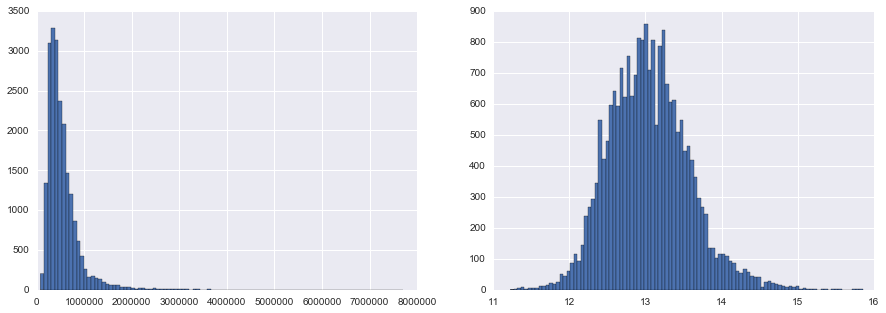

Normal Mean:  540088.141767 +- 367118.703181
Logged Mean:  13.0478169172 +- 0.526672334454


In [32]:
df['log_price'] = np.log(df['price'])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(df['price'], bins = 100)

# Logging gives it a gaussian and less skewed data
ax2.hist(np.log(df['price']), bins = 100)
plt.show()

print "Normal Mean: ", np.mean(df['price']), "+-", np.std(df['price'])
print "Logged Mean: ", np.mean(np.log(df['price'])), "+-", np.std(np.log(df['price']))

## Price Association with Other Variables

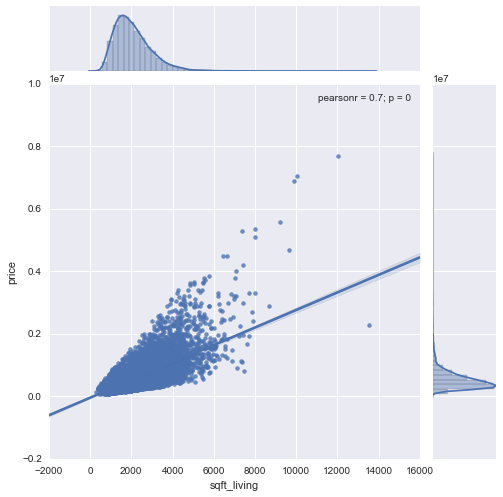

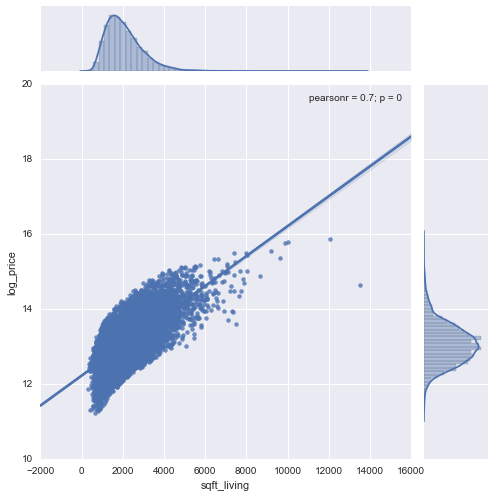

In [33]:
"""
r = .7, and therefore very correlated. 
This agrees with intuition that the bigger the house the pricier.
"""
sns.jointplot(x="sqft_living", y="price", data=df, kind = 'reg', size = 7)
plt.show()

sns.jointplot(x="sqft_living", y="log_price", data=df, kind = 'reg', size = 7)
plt.show()

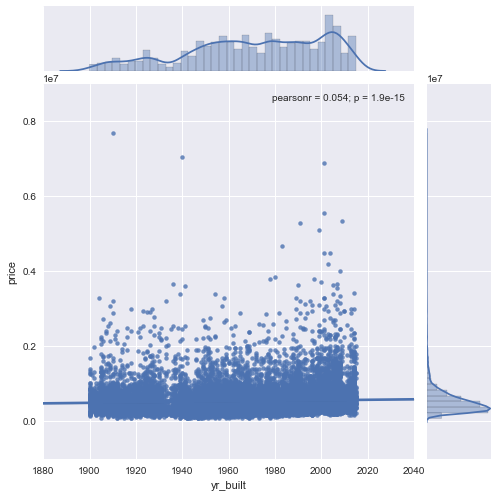

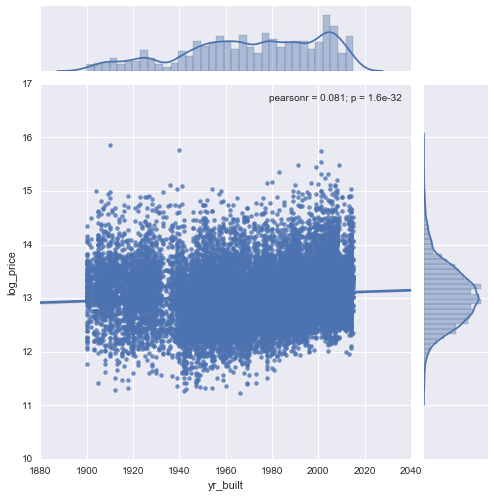

In [36]:
"""
Seems like the year it was built doesn't have that much of an effect in Seattle.
"""
sns.jointplot(x="yr_built", y="price", data=df, kind = 'reg', size = 7)
sns.jointplot(x="yr_built", y="log_price", data=df, kind = 'reg', size = 7)

plt.show()

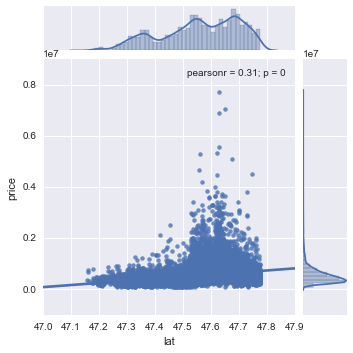

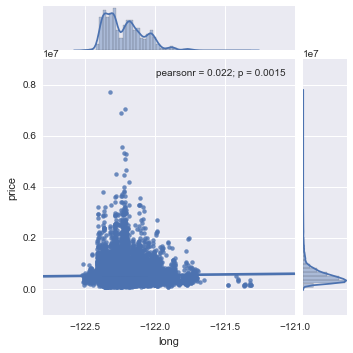

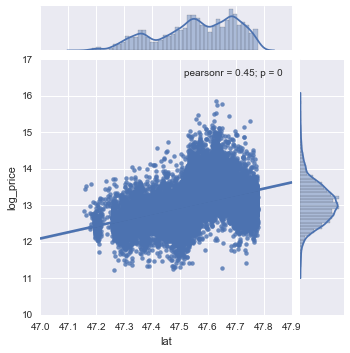

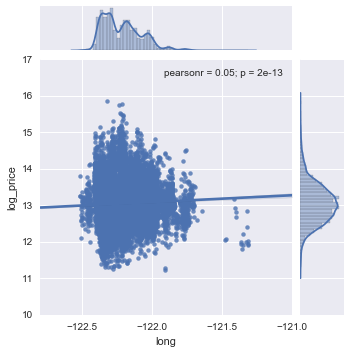

In [38]:
sns.jointplot(x="lat", y="price", data=df, kind = 'reg', size = 5)
sns.jointplot(x="long", y="price", data=df, kind = 'reg', size = 5)

sns.jointplot(x="lat", y="log_price", data=df, kind = 'reg', size = 5)
sns.jointplot(x="long", y="log_price", data=df, kind = 'reg', size = 5)
plt.show()

## Categories of Interest

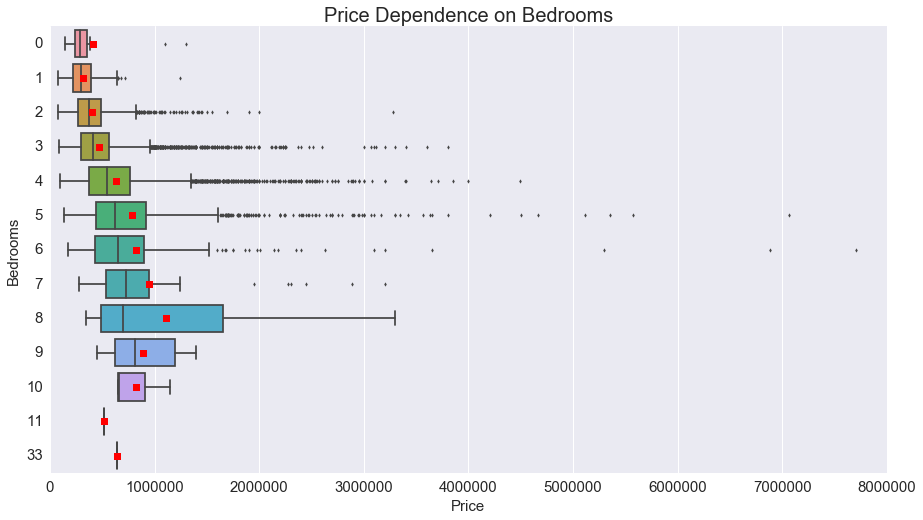

In [59]:
"""
These might not look like big changes, but the graph is on order of millions.
Therefore, the prices are on order of hundred thousands
"""
fig, axarr = plt.subplots(1,1,figsize=(15,8))
sns.boxplot(y = 'bedrooms', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr)
plt.tick_params(which ='both', labelsize = 15)
plt.xlabel('Price',fontsize = 15)
plt.ylabel('Bedrooms',fontsize = 15)
plt.title('Price Dependence on Bedrooms', fontsize = 20)
plt.show()

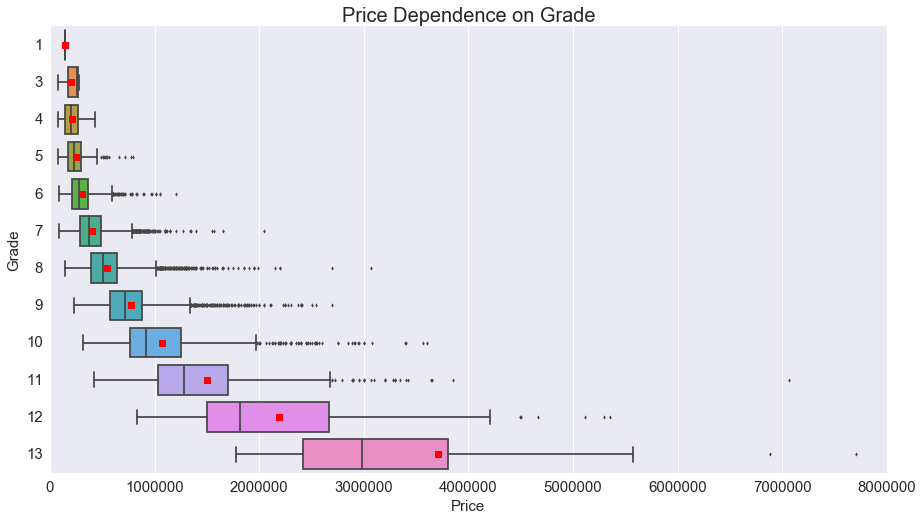

In [55]:
fig, axarr = plt.subplots(1,1,figsize=(15,8))
sns.boxplot(y = 'grade', x = 'price', data = df, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr)
plt.tick_params(which ='both', labelsize = 15)
plt.xlabel('Price',fontsize = 15)
plt.ylabel('Grade',fontsize = 15)
plt.title('Price Dependence on Grade', fontsize = 20)
plt.show()

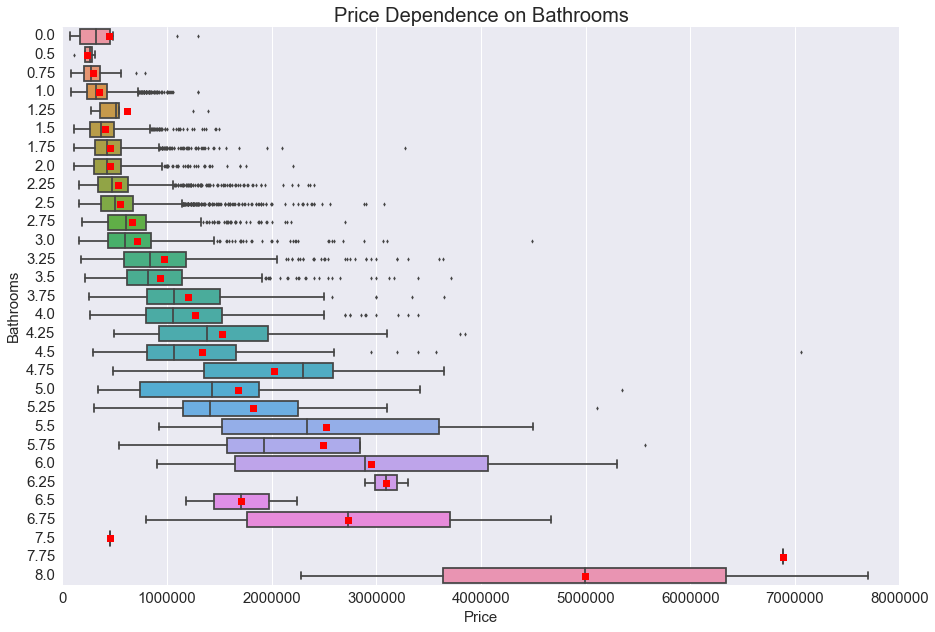

In [54]:
fig, axarr = plt.subplots(1,1,figsize=(15,10))
sns.boxplot(y = 'bathrooms', x = 'price', data = df, width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = axarr)
plt.tick_params(which ='both', labelsize = 15)
plt.xlabel('Price',fontsize = 15)
plt.ylabel('Bathrooms',fontsize = 15)
plt.title('Price Dependence on Bathrooms', fontsize = 20)
plt.show()

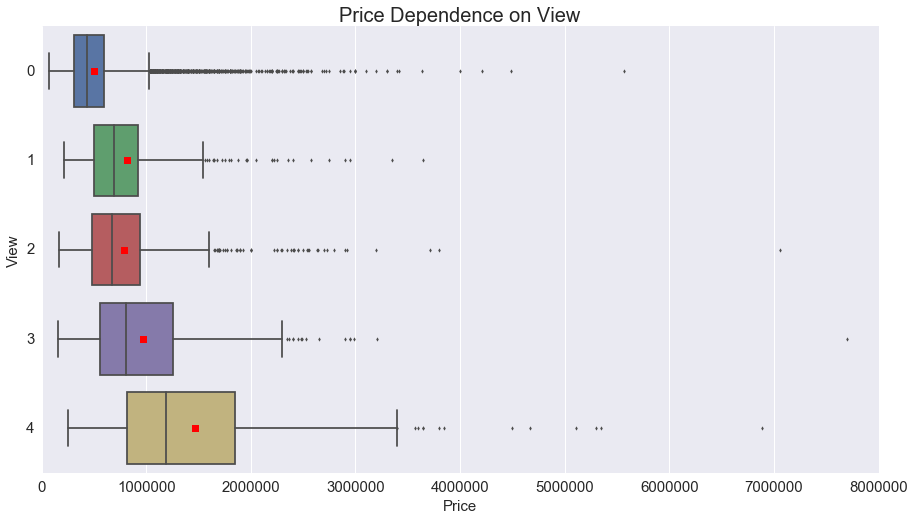

In [57]:
"""
Lets be honest, anywhere is a nice view in Seattle. 
However, there are premium views.
"""
fig, axarr = plt.subplots(1,1,figsize=(15,8))
sns.boxplot(y = 'view', x = 'price', data = df, width = 0.8, orient = 'h', showmeans = True, fliersize = 3, ax = axarr)
plt.tick_params(which ='both', labelsize = 15)
plt.xlabel('Price',fontsize = 15)
plt.ylabel('View',fontsize = 15)
plt.title('Price Dependence on View', fontsize = 20)
plt.show()

## Data and Visualization Conclusion: Continue to ML - Regression
It seems our data corresponds well with a exponential value better than linear.  
This gives me the impression that it grows exponentially as the sqft increases anyways.